In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, classification_report
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns


#Étape 1 : Préparation des Données

1.Charger les Données Charger les données depuis le fichier CSV

In [35]:
# Configurer les options de visualisation
sns.set(style="whitegrid")

### 1. Chargement des données
# Remplacer par le chemin de votre fichier CSV
df = pd.read_csv("/content/all_logs.csv")

print("Aperçu des données :")
print(df.head())


Aperçu des données :
                               Date   Hostname          Process  IdProcess  \
0  2024-12-11T17:14:51.738480+01:00  hilbert02      gnome-shell     2026.0   
1  2024-12-11T17:20:14.050043+01:00  hilbert02  gnome-text-edit     6677.0   
2  2024-12-11T17:30:47.240173+01:00  hilbert02  gnome-text-edit     6677.0   
3  2024-12-11T17:33:26.216539+01:00  hilbert02      gnome-shell     2026.0   
4  2024-12-11T17:37:43.354684+01:00  hilbert02      gnome-shell     2026.0   

                                             Message  
0  meta_window_set_stack_position_no_sync: assert...  
1  Trying to snapshot GtkGizmo 0x559f9a9e7800 wit...  
2  Trying to snapshot GtkGizmo 0x559f9a9e7800 wit...  
3  JS ERROR: TypeError: this.actor is null#012_sy...  
4  endSessionDialog: No XDG_SESSION_ID, fetched f...  


2.Nettoyage des Données Gérer les valeurs manquantes (e.g., NaN dans IdProcess).
Supprimer ou remplacer les valeurs non pertinentes.

In [36]:
### 2. Prétraitement et nettoyage
# Suppression des valeurs manquantes
print("Données manquantes avant nettoyage :")
print(df.isnull().sum())

# Remplacer les NaN dans les messages par une chaîne vide
df['Message'] = df['Message'].fillna("")


Données manquantes avant nettoyage :
Date          43615
Hostname      43615
Process       43615
IdProcess    113339
Message       43615
dtype: int64


###3. Normalisation des Timestamps
Convertir les dates pour une manipulation uniforme.

In [37]:
# Conversion des dates en format datetime
df['Date'] = pd.to_datetime(df['Date'])

# Afficher le format des dates
print(df['Date'].dtypes)

datetime64[ns, UTC+01:00]


In [38]:
### 3. Encodage des colonnes catégoriques
encoder = LabelEncoder()
df['Process_encoded'] = encoder.fit_transform(df['Process'])
df['Hostname_encoded'] = encoder.fit_transform(df['Hostname'])

print("Encodage des colonnes effectué")


Encodage des colonnes effectué


###4. Extraire les Catégories
Ajouter des colonnes dérivées, comme le type d’erreur basé sur Message.

In [39]:
# Ajouter une colonne 'ErrorType' basée sur les mots-clés dans 'Message'
def categorize_message(message):
  message= str(message)
  if "Error" in message:
        return "Error"
  elif "Warning" in message:
        return "Warning"
  else:
        return "Info"

df['ErrorType'] = df['Message'].apply(categorize_message)

# Vérifier la distribution des catégories
print(df['ErrorType'].value_counts())


ErrorType
Info       185528
Error        1109
Warning       115
Name: count, dtype: int64


#Étape 2 : Analyse Exploratoire

###1. Statistiques de Base : Obtenir des statistiques sur les processus, les hôtes et les erreurs.

In [40]:
# Comptage des occurrences par Processus
process_count = df['Process'].value_counts()

# Comptage des erreurs par Type
error_count = df['ErrorType'].value_counts()

print("Comptage des Processus :\n", process_count)
print("Comptage des Erreurs :\n", error_count)


Comptage des Processus :
 Process
kernel             60956
systemd            18133
gnome-software     17666
nautilus            8268
rtkit-daemon        7025
                   ...  
gsd-keyboard           2
gsd-wacom              2
mutter-x11-fram        2
gsd-xsettings          2
seahorse               2
Name: count, Length: 376, dtype: int64
Comptage des Erreurs :
 ErrorType
Info       185528
Error        1109
Warning       115
Name: count, dtype: int64


2. Analyse Temporelle
Étude de la répartition des logs au fil du temps.

<ipython-input-41-b3b1a442ee9f>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  logs_per_hour = df.resample('H').size()


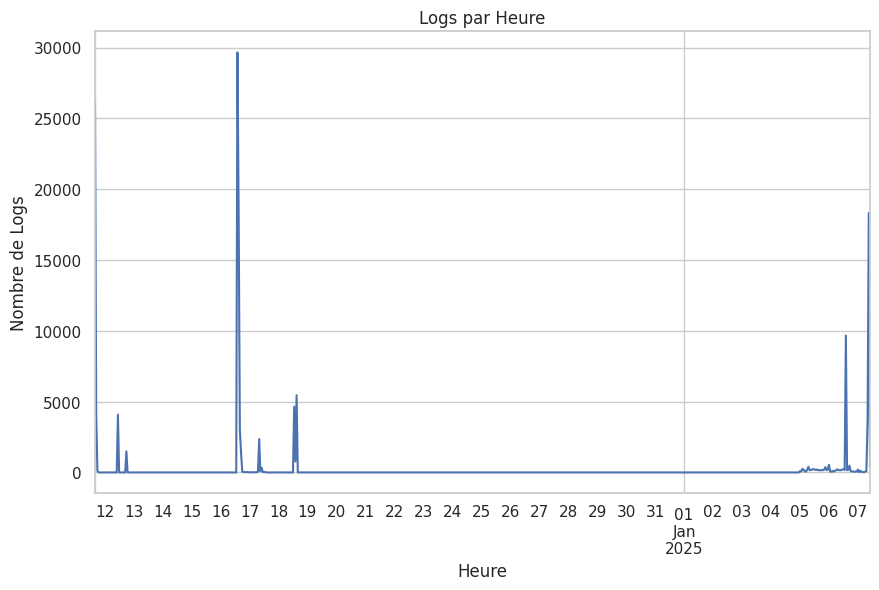

In [41]:
# Grouper par date pour analyser les fréquences
df.set_index('Date', inplace=True)
logs_per_hour = df.resample('H').size()

# Visualiser les logs par heure
logs_per_hour.plot(kind='line', title="Logs par Heure", figsize=(10, 6))
plt.xlabel("Heure")
plt.ylabel("Nombre de Logs")
plt.show()


3. Processus avec Anomalies
Identifier les processus générant des erreurs fréquentes.

In [42]:
# Filtrer les erreurs
error_logs = df[df['ErrorType'] == 'Error']

# Comptage des erreurs par Processus
error_by_process = error_logs['Process'].value_counts()

print("Erreurs par Processus :\n", error_by_process)

Erreurs par Processus :
 Process
gnome-shell                       277
gnome-session                     114
gsd-power                          76
xdg-desktop-por                    60
wireplumber                        60
gsd-sharing                        60
gnome-session-binary               57
gsd-usb-protect                    30
at-spi2-registr                    30
evolution-alarm                    30
org.gnome.Shell.desktop            30
evolution-addre                    20
evolution-calen                    20
kdeconnectd                        20
firefox-esr.desktop[6754]          20
gsd-power[12933]                   18
nautilus                           12
gsd-sharing[1492]                  12
kernel                             11
gvfsd                              11
gnome-session[2123]                 8
gnome-shell[2156]                   7
gsd-sharing[1534]                   6
gsd-sharing[12853]                  6
gnome-session[2097]                 6
gsd-power[2354]  

#3. Vectorisation des messages avec TF-IDF

In [43]:

### 3. Vectorisation des messages avec TF-IDF
tfidf = TfidfVectorizer(max_features=100)
X_text_features = tfidf.fit_transform(df['Message']).toarray()

# Création de la matrice des features pour les modèles
X = np.hstack((X_text_features, df[['Process_encoded', 'Hostname_encoded']].values))


#Etape 4. Détection d'anomalies

In [45]:
### 5. Détection d'anomalies avec Isolation Forest
iso_forest = IsolationForest(contamination=0.01, random_state=42)
df['Anomaly'] = iso_forest.fit_predict(X)

# Afficher les anomalies
anomalies = df[df['Anomaly'] == -1]
print("Nombre d'anomalies détectées :", len(anomalies))
print(anomalies[['Process', 'Message']].head())
print(anomalies.index[:5])  # Print first 5 date-time index values


Nombre d'anomalies détectées : 1848
                                 Process  \
Date                                       
2024-12-11 16:37:41.603452+01:00   nslcd   
2024-12-11 16:37:41.603709+01:00   nslcd   
2024-12-11 16:37:41.603828+01:00   nslcd   
2024-12-11 16:37:41.603948+01:00   nslcd   
2024-12-11 16:47:06.467803+01:00   nslcd   

                                                                            Message  
Date                                                                                 
2024-12-11 16:37:41.603452+01:00  [465f01] <group/member="man"> no available LDA...  
2024-12-11 16:37:41.603709+01:00  [465f01] <group/member="man"> no available LDA...  
2024-12-11 16:37:41.603828+01:00  [24c67e] <group/member="man"> no available LDA...  
2024-12-11 16:37:41.603948+01:00  [24c67e] <group/member="man"> no available LDA...  
2024-12-11 16:47:06.467803+01:00  [63b9ea] <group/member="root"> no available LD...  
DatetimeIndex(['2024-12-11 16:37:41.603452+01:00',
  

<ipython-input-46-13b5e1c9ee1a>:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  anomaly_indices = anomalies.index.floor('H') # Floor timestamps to the nearest hour


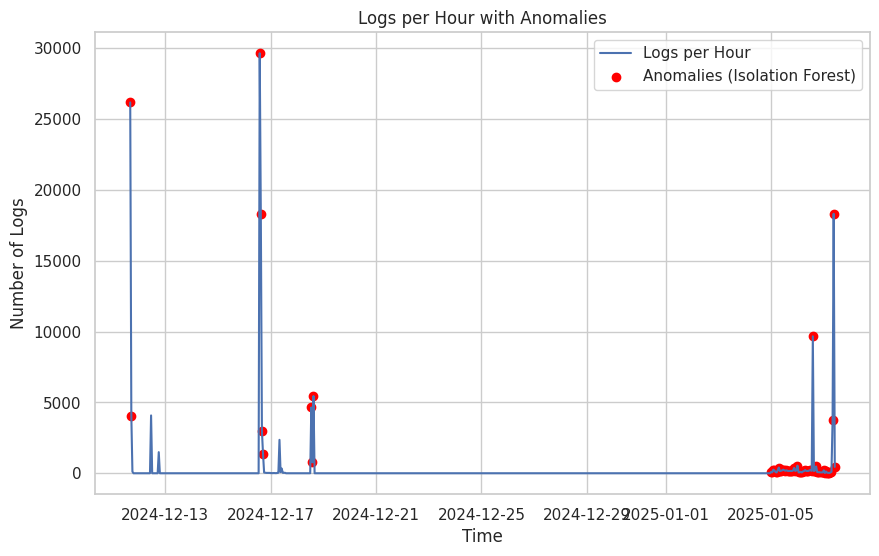

In [46]:
plt.figure(figsize=(10,6))
plt.plot(logs_per_hour.index, logs_per_hour.values, label='Logs per Hour')

# Get the hourly timestamps from anomalies_if
anomaly_indices = anomalies.index.floor('H') # Floor timestamps to the nearest hour

# Only select anomalies that exist in logs_per_hour
# This step is crucial for aligning the indices
common_indices = anomaly_indices.intersection(logs_per_hour.index)
anomaly_values = logs_per_hour.loc[common_indices]

plt.scatter(common_indices, anomaly_values, color='red', label='Anomalies (Isolation Forest)')

plt.title('Logs per Hour with Anomalies')
plt.xlabel('Time')
plt.ylabel('Number of Logs')
plt.legend()
plt.show()

ce graphique montre une évolution des logs par heure avec une détection d'anomalies marquées par des points rouges, principalement corrélées à des pics massifs d'activité. Ces pics, particulièrement concentrés autour de la mi-décembre 2024, dépassent les 20 000 logs par heure, ce qui constitue une déviation majeure par rapport aux volumes standards. Une hausse moins prononcée est également visible début janvier 2025. La concentration des anomalies sur ces périodes suggère des incidents critiques tels que des pannes système, des surcharges liées à une maintenance, voire des attaques potentielles (type Denial of Service). Cette situation nécessite une analyse approfondie des types d'erreurs associés et une surveillance en temps réel pour anticiper ou prévenir ces anomalies à l’avenir.

#Etape 5: Classification Supervisée des messages

In [47]:
### 5. Classification supervisée des messages
# Génération de labels fictifs pour l'exemple (1 pour erreur, 0 pour non-erreur)
df['Label'] = df['Message'].apply(lambda x: 1 if "error" in x.lower() else 0)

X_train, X_test, y_train, y_test = train_test_split(X, df['Label'], test_size=0.2, random_state=42)

# Modèle Random Forest
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [48]:
# Prédictions et évaluation
y_pred = clf.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred))
print("Rapport de classification :")
print(classification_report(y_test, y_pred))


Accuracy : 0.9999464539102032
Rapport de classification :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     37027
           1       1.00      0.99      1.00       324

    accuracy                           1.00     37351
   macro avg       1.00      1.00      1.00     37351
weighted avg       1.00      1.00      1.00     37351



# 6. Clustering avec K-Means

In [49]:
### 7. Clustering avec K-Means
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)



/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


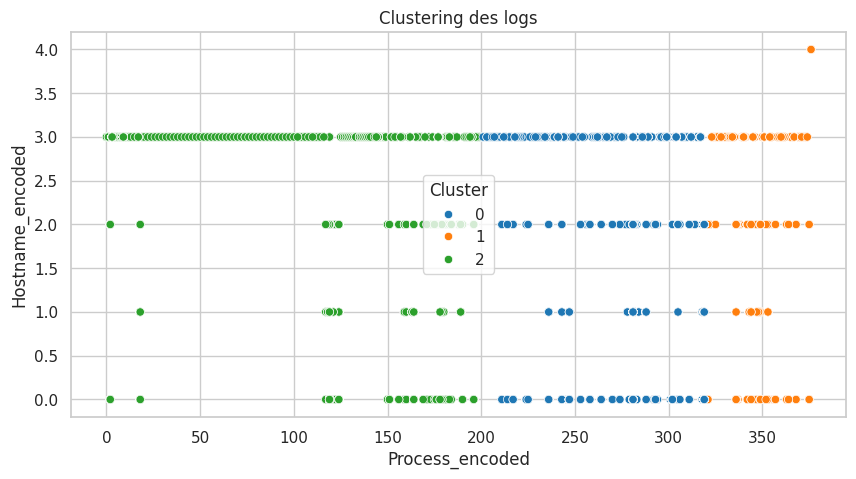

In [50]:
# Visualisation des clusters
plt.figure(figsize=(10, 5))
sns.scatterplot(x=df['Process_encoded'], y=df['Hostname_encoded'], hue=df['Cluster'], palette='tab10')
plt.title("Clustering des logs")
plt.show()

On observe une bonne séparation entre les groupes, ce qui indique une différenciation nette des logs selon les processus et les hôtes associés. Les clusters semblent répartis selon des plages spécifiques de processus, suggérant des comportements homogènes pour certains processus ou groupes de machines.

Le cluster 1 (vert) présente une dispersion plus large sur les hôtes, tandis que les clusters 0 (bleu) et 2 (orange) sont concentrés autour de certaines plages de processus.

# 7. Prévision temporelle avec ARIMA

In [54]:
### 7. Prévision temporelle avec ARIMA
# Conversion de la colonne Date
df_time_series = df.resample('H').size()
# Modèle ARIMA
model = ARIMA(df_time_series, order=(5, 1, 0))
results = model.fit()

<ipython-input-54-59eccc56c40d>:3: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_time_series = df.resample('H').size()
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)


In [55]:
# Prévisions
forecast = results.forecast(steps=10)
print("Prévisions pour les 10 prochaines heures :")
print(forecast)

Prévisions pour les 10 prochaines heures :
2025-01-07 11:00:00+01:00    1018.406844
2025-01-07 12:00:00+01:00    3468.290117
2025-01-07 13:00:00+01:00    3795.756860
2025-01-07 14:00:00+01:00    4499.840494
2025-01-07 15:00:00+01:00    5633.938272
2025-01-07 16:00:00+01:00    3996.252232
2025-01-07 17:00:00+01:00    3597.199612
2025-01-07 18:00:00+01:00    3967.658709
2025-01-07 19:00:00+01:00    4132.854073
2025-01-07 20:00:00+01:00    4239.420579
Freq: h, Name: predicted_mean, dtype: float64


# 8. Visualisation des anomalies

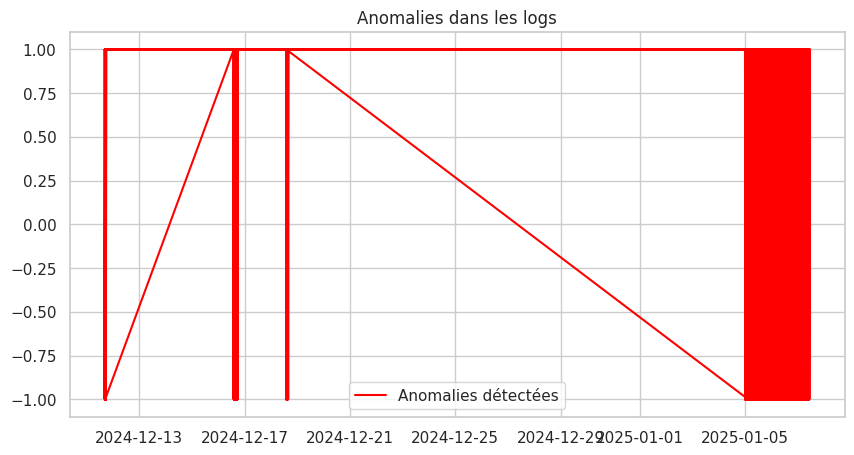

In [65]:
### 8. Visualisation des anomalies
plt.figure(figsize=(10, 5))

# The 'Date' is likely the index, so reset it before dropna
df_cleaned = df.reset_index().dropna(subset=['Date'])

plt.plot(df_cleaned['Date'], df_cleaned['Anomaly'], color='red', label='Anomalies détectées')
plt.title("Anomalies dans les logs")
plt.legend()
plt.show()

# Rapports sur les processus les plus actifs et les erreurs


In [66]:
# Rapports sur les processus les plus actifs
top_processes = df['Process'].value_counts().head(10)

# Rapports sur les erreurs
top_errors = error_logs['Message'].value_counts().head(10)

print("Top 10 Processus :\n", top_processes)
print("Top 10 Messages d'erreurs :\n", top_errors)


Top 10 Processus :
 Process
kernel            60956
systemd           18133
gnome-software    17666
nautilus           8268
rtkit-daemon       7025
nslcd              5676
packagekitd        3568
dbus-daemon        3286
gnome-shell        2965
anacron            1296
Name: count, dtype: int64
Top 10 Messages d'erreurs :
 Message
Error reading events from display: Relais brisé (pipe)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             130
Received error from D-Bus search provi

In [113]:
import plotly.express as px

# Couleurs personnalisées pour les types d'erreur
color_map = {
    "Info": "purple",
    "Error": "red",
    "Warning": "yellow"
}

# Diagramme circulaire avec couleurs spécifiques, using the 'Count' column from pie_chart_df
fig_pie = px.pie(
    pie_chart_df,  # Use pie_chart_df instead of df
    names='ErrorType',
    title="Répartition des Types d'Erreurs",
    hole=0.3,
    values='Count',  # Use 'Count' for values
    color='ErrorType',
    color_discrete_map=color_map
)

fig_pie.update_traces(textinfo='percent+label')
fig_pie.show()

In [104]:
import plotly.graph_objects as go

# Top 10 des processus
top_processes = df['Process'].value_counts().head(10)

# Histogramme
fig_bar = go.Figure()
fig_bar.add_trace(go.Bar(
    x=top_processes.index,
    y=top_processes.values,
    marker_color='skyblue'
))

fig_bar.update_layout(
    title="Top 10 Processus",
    xaxis_title="Processus",
    yaxis_title="Nombre de logs",
    template="plotly_white"
)

fig_bar.show()